In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [40]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [41]:
# img_tgt
# nca_tgt
# img_clip
# nca_clip

In [5]:
prompts = [
    "a red apple",
    # "a photo of a red apple",
    # "a green tree",
    "a very fat cat",
    "a bustling luscious nature landscape",
    "an artificial life simulation",
    # "self-replication emerging in an artificial life simulation",
    # "a photo of the emergence of open-ended complexity",
]

In [6]:
tgt_imgs = [
    "/home/akarshkumar0101/nca-alife-data/target_imgs/gorilla.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/nature.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/confetti_ball.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/einstein.png",
]

In [21]:
group.add_argument("--seed", type=int, default=0)
group.add_argument("--save_dir", type=str, default=None)
group.add_argument("--dtype", type=str, default='float32')
group.add_argument("--device", type=str, default='cuda:0')

group = parser.add_argument_group("model")
group.add_argument("--img_size", type=int, default=224)
group.add_argument("--substrate", type=str, default='img')
# img params
group.add_argument("--init", type=str, default='randn')

# nca params
group.add_argument("--n_layers", type=int, default=2)
group.add_argument("--d_state", type=int, default=16)
group.add_argument("--d_embd", type=int, default=32)
group.add_argument("--kernel_size", type=int, default=3)
group.add_argument("--nonlin", type=str, default="GELU")

group.add_argument("--init_state", type=str, default='randn')
group.add_argument("--dt", type=float, default=0.01)
group.add_argument("--p_drop", type=float, default=0.0)
group.add_argument("--n_steps", type=int, default=64)

group = parser.add_argument_group("data")
group.add_argument("--target_img_path", type=str, default=None)
group.add_argument("--prompt", type=str, default=None)
group.add_argument("--n_augs", type=int, default=4)
group.add_argument("--augs", type=str, default="")  # crop+pers+jitter

group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

group = parser.add_argument_group("optimization")
group.add_argument("--bs", type=int, default=1)
group.add_argument("--lr", type=float, default=1e-3)
group.add_argument("--n_iters", type=int, default=10000)

NameError: name 'group' is not defined

In [7]:
cfg_default = dict(seed=0, save_dir=None,
                   img_size=64, substrate=None,
                   init='zeros',
                   n_layers=2, d_state=16, d_embd=32,
                   init_state='point', padding_mode='zeros', dt=0.01, p_drop=0., n_steps=64,
                   target_img_path=None,
                   prompt=None, n_augs=1, augs="",
                   bs=1, lr=1e-3, n_iters=100000)

n_seeds = 4
cfgs = []

# for seed in range(n_seeds):
#     for i_tgt, tgt in enumerate(tgt_imgs):
#         # for init_state in ['zeros', 'point', 'randn']:
#         for init_state in ['point']:
#             cfg = cfg_default.copy()
#             cfg.update(seed=seed, substrate='nca', init_state=init_state, target_img_path=tgt)
#             cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_tgt_{i_tgt}_{init_state}_{seed}")
#             cfg.update(n_iters=100)
#             cfgs.append(cfg)

for seed in range(n_seeds):
    for i_prompt, prompt in enumerate(prompts):
        cfg = cfg_default.copy()
        cfg.update(seed=seed, substrate='img', prompt=prompt, n_augs=4, augs="crop+pers", bs=4)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/img_clip_{i_prompt}_{seed}")
        cfgs.append(cfg)
    for i_prompt, prompt in enumerate(prompts):
        cfg = cfg_default.copy()
        cfg.update(seed=seed, substrate='nca', prompt=prompt, n_augs=4, augs="crop+pers", bs=4)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_{i_prompt}_{seed}")
        cfgs.append(cfg)


In [8]:
commands = experiment_utils.create_commands(cfgs, prefix='python clip_nca_optim_torch.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python clip_nca_optim_torch.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/img_clip_0_0" --img_size=64 --substrate="img" --init="zeros" --n_layers=2 --d_state=16 --d_embd=32 --init_state="point" --padding_mode="zeros" --dt=0.01 --p_drop=0.0 --n_steps=64 --target_img_path=None --prompt="a red apple"                          --n_augs=4 --augs="crop+pers" --bs=4 --lr=0.001 --n_iters=100000
python clip_nca_optim_torch.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/img_clip_1_0" --img_size=64 --substrate="img" --init="zeros" --n_layers=2 --d_state=16 --d_embd=32 --init_state="point" --padding_mode="zeros" --dt=0.01 --p_drop=0.0 --n_steps=64 --target_img_path=None --prompt="a very fat cat"                       --n_augs=4 --augs="crop+pers" --bs=4 --lr=0.001 --n_iters=100000
python clip_nca_optim_torch.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/img_clip_2_0" --img_size=64 --substrate=

# Visualize Results

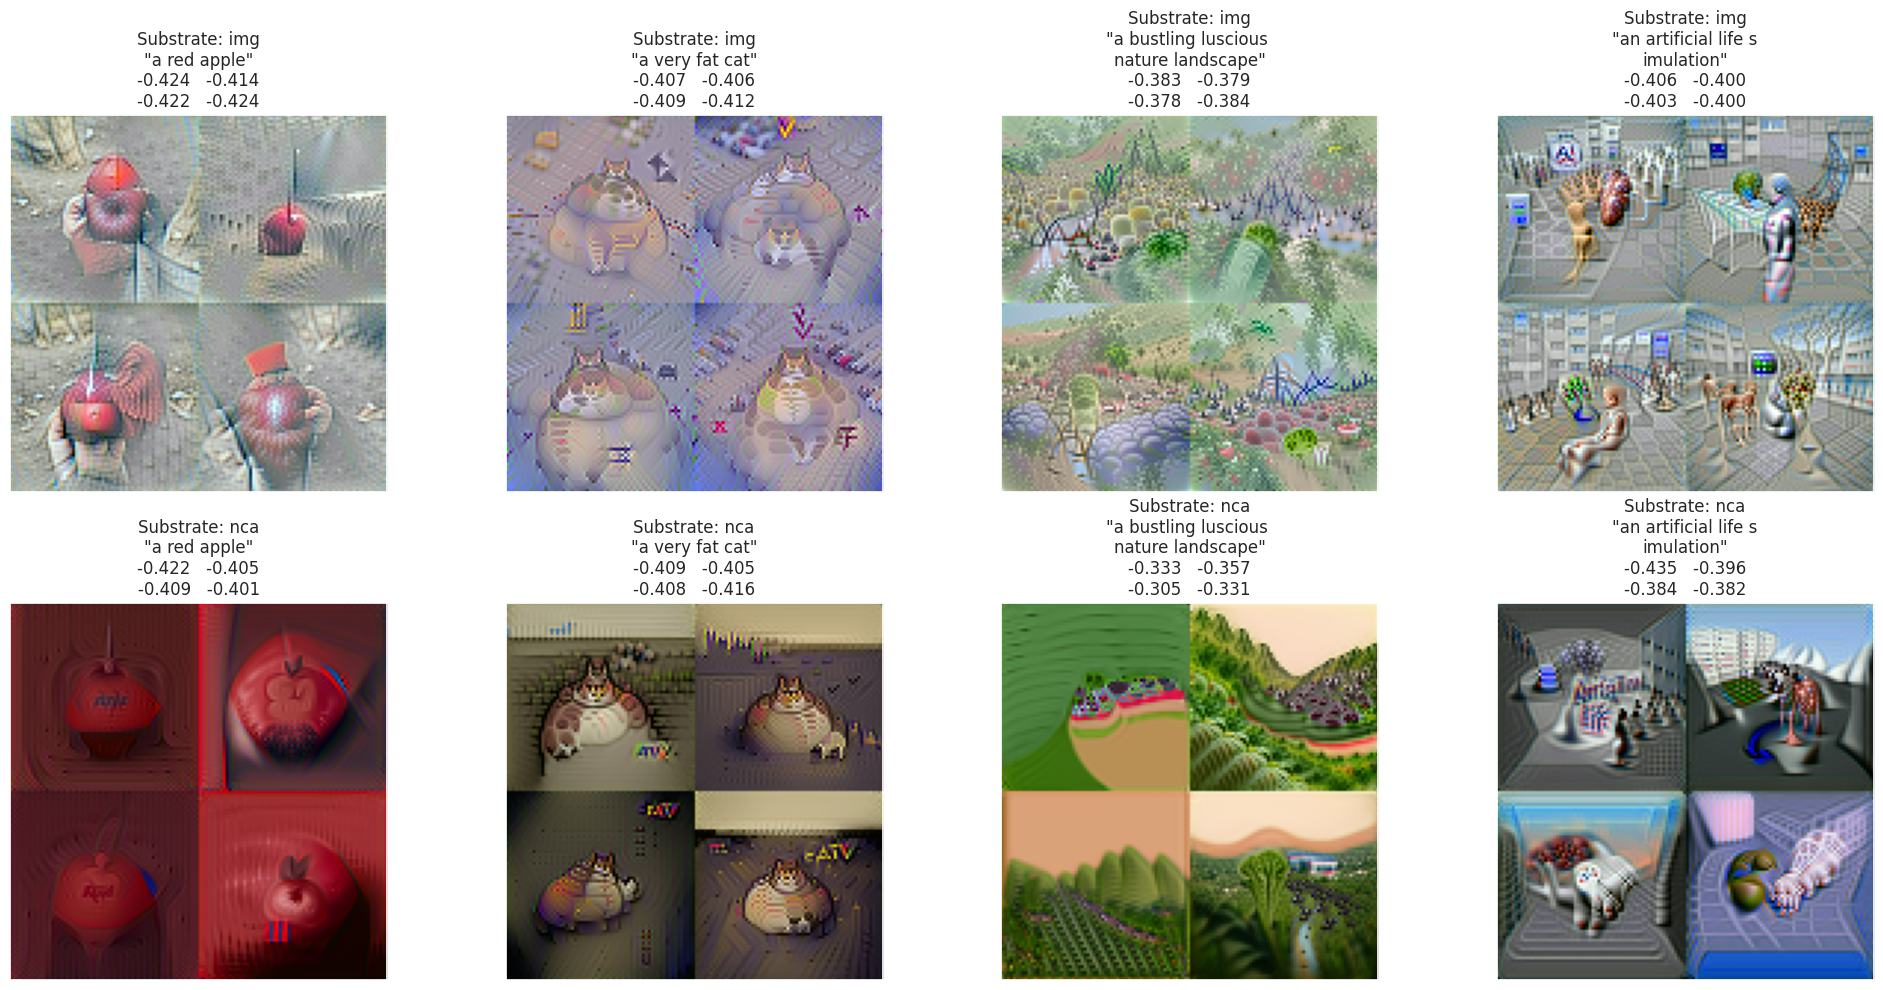

In [9]:
plt.figure(figsize=(20, 10))
subs = ['img', 'nca']
i = 0
for i_sub, substrate in enumerate(subs):
    for i_prompt, prompt in enumerate(prompts):
        imgs = []
        losses = []
        for seed in range(n_seeds):
            save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/{substrate}_clip_{i_prompt}_{seed}"
            imgs.append(util.load_pkl(save_dir, 'img').astype(np.float32))
            losses.append(util.load_pkl(save_dir, 'losses').mean().item())
        imgs = rearrange(imgs, '(R C) H W D -> (R H) (C W) D', R=2, C=2)

        i += 1
        plt.subplot(len(subs), len(prompts), i)
        plt.imshow(imgs)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        prompt_display = '\n'.join([prompt[i:i+20] for i in range(0, len(prompt), 20)])
        plt.title(f"Substrate: {substrate}\n\"{prompt_display}\"\n{losses[0]:.3f}   {losses[1]:.3f}\n{losses[2]:.3f}   {losses[3]:.3f}")

plt.tight_layout()

In [11]:
import torch
save_dir = f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/{'nca'}_clip_{2}_{1}"
sd = torch.load(f"{save_dir}/nca.pt")
device = 'cuda'
dtype = torch.float

In [28]:
from models_torch import NCAWrapper, sample_init_state
nca = NCAWrapper(2, 16, 32,  kernel_size=3, nonlin='GELU', padding_mode='zeros', dt=0.01, p_drop=0., n_steps=64).to(device, dtype)
nca.load_state_dict(sd)

<All keys matched successfully>

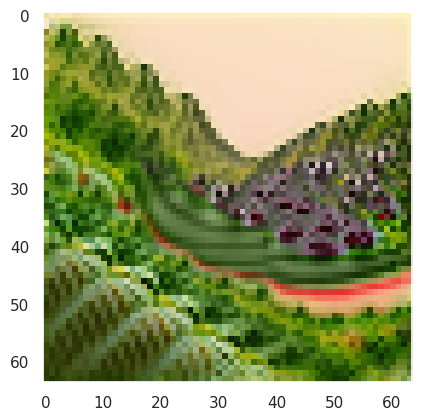

In [34]:
def create_image():
    state = sample_init_state(64, 64, 16, 1, 'point', device=device, dtype=dtype)
    state, obs = nca(state)
    return rearrange(torch.sigmoid(obs), 'B D H W -> B H W D')
plt.imshow(create_image().detach().cpu().numpy()[0])
plt.grid(False)

In [54]:
@torch.no_grad()
def create_video():
    state = sample_init_state(64, 64, 16, 1, 'point', device=device, dtype=dtype)
    vid = []
    for t in range(64+1):
        state, obs = nca.forward_step(state)
        vid.append(obs)
    return torch.sigmoid(rearrange(vid, 'T B D H W -> B T H W D'))

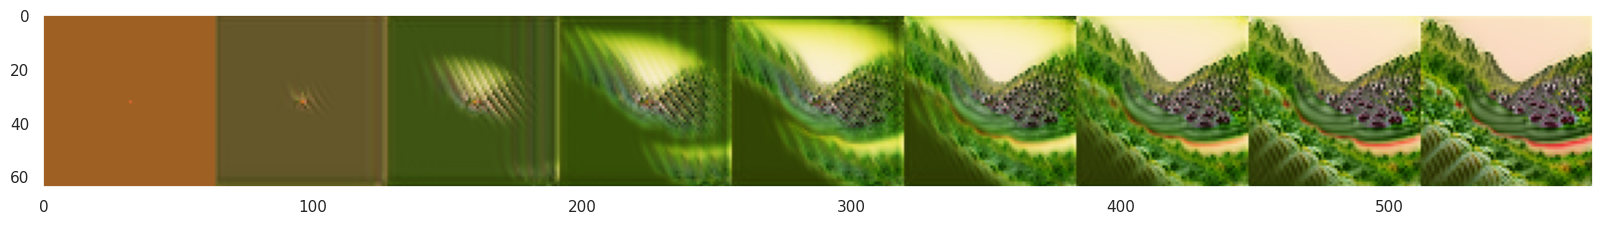

In [57]:
vid = create_video()[0].detach().cpu().numpy().astype(np.float32)
plt.figure(figsize=(20, 3))
plt.imshow(rearrange(vid[::8], 'T H W D -> H (T W) D'))
plt.grid(False)

array([ 0,  8, 16, 24, 32, 40, 48, 56, 64])

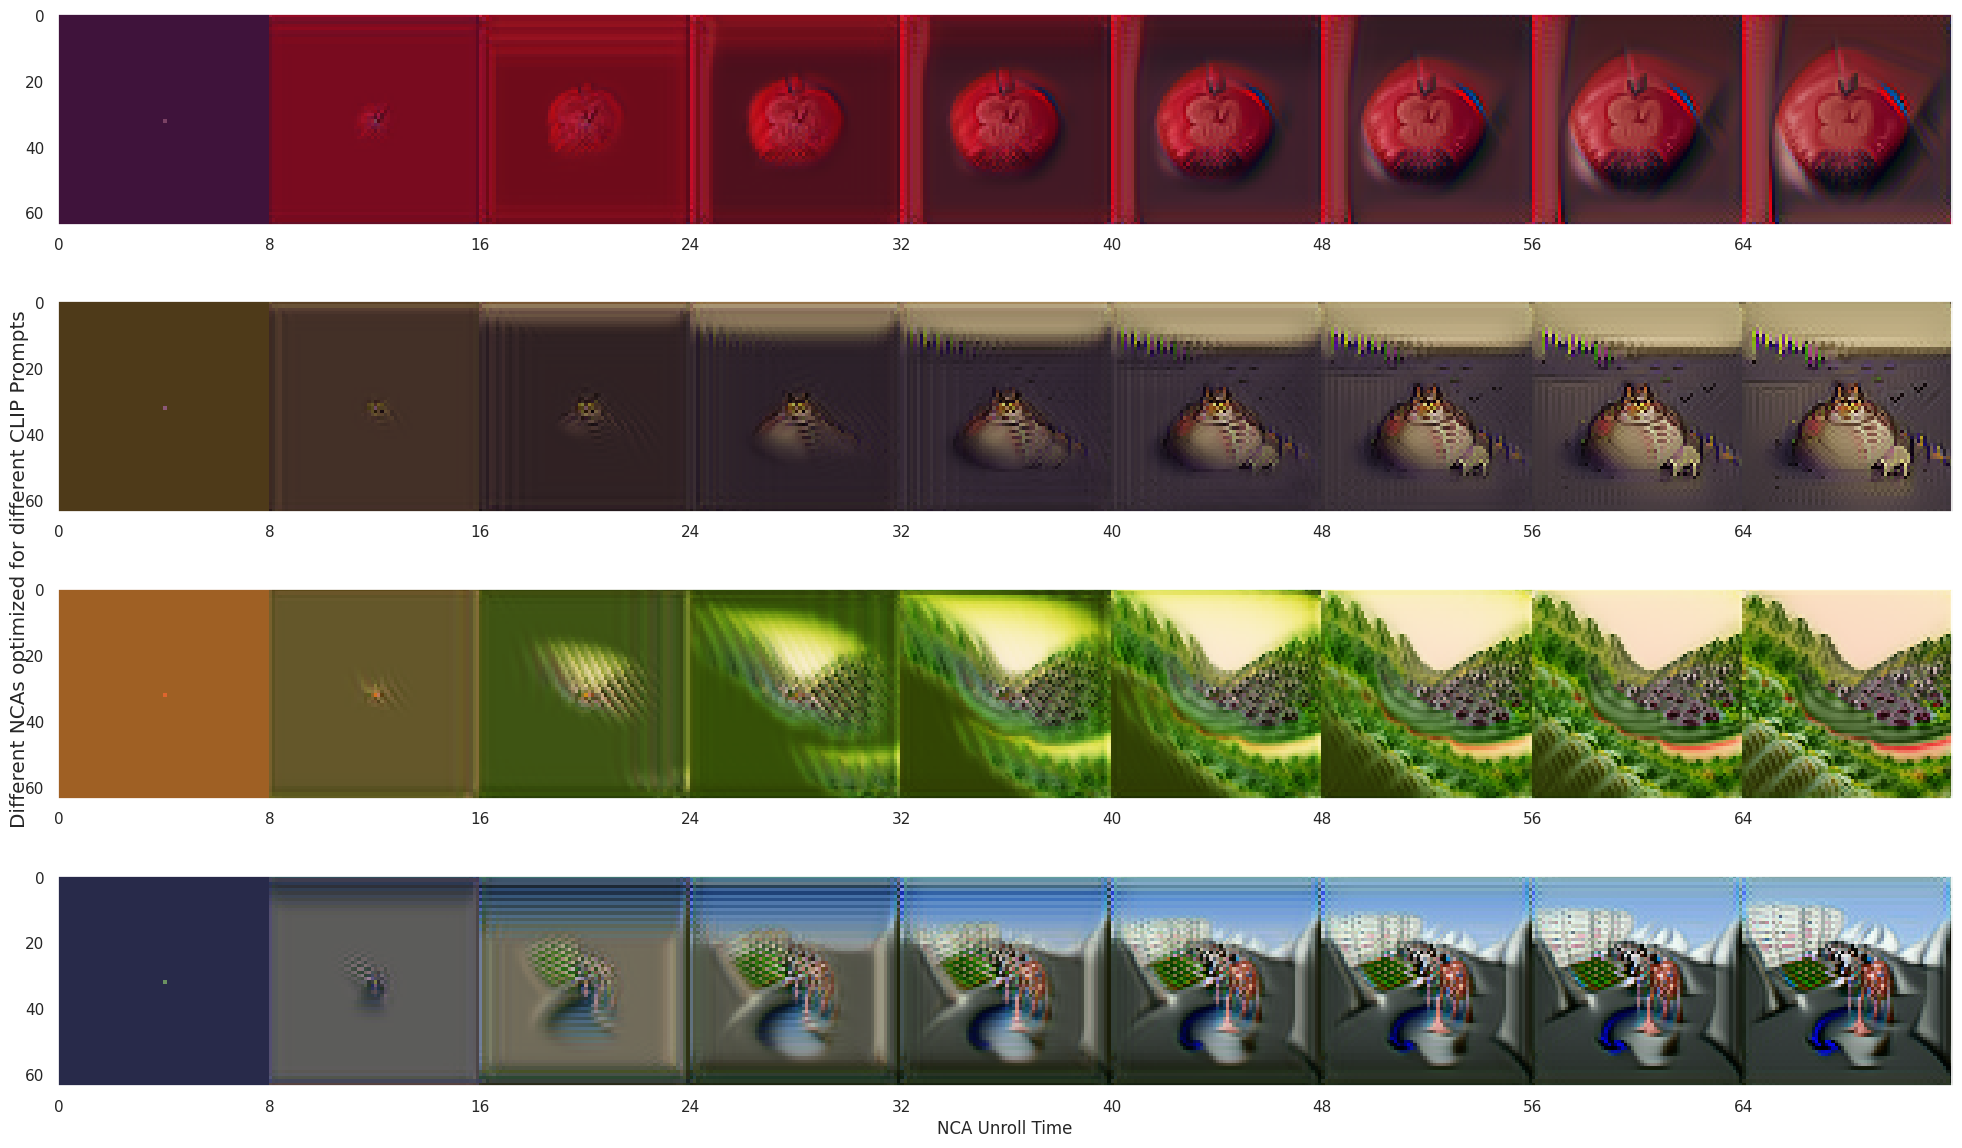

In [76]:
plt.figure(figsize=(20, 3*4))
for i in range(4):
    save_dir = f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/{'nca'}_clip_{i}_{1}"
    sd = torch.load(f"{save_dir}/nca.pt")
    nca.load_state_dict(sd)
    vid = create_video()[0].detach().cpu().numpy().astype(np.float32)
    plt.subplot(4, 1, i+1)
    plt.imshow(rearrange(vid[::8], 'T H W D -> H (T W) D'))
    plt.grid(False)

    plt.xticks(np.arange(0, 65, 8)*8, np.arange(0, 65, 8))

plt.xlabel("NCA Unroll Time")
plt.gcf().supylabel("Different NCAs optimized for different CLIP Prompts")

plt.tight_layout()
plt.show()

In [77]:
sum(p.numel() for p in nca.parameters())

19619